In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from ag_utils import Corpus
from ag_utils import parse_ag_file
from ag_utils import parse_node_properties

from synthetic_data import gene_dataset

from models import NN, GCN, GAT, GCN_EW
from model_utils import train, predict_prob, evaluate_performance

In [2]:
# parse attack graph file generated by MulVAL tool
attack_graph_path = '../mulval_attack_graph/AttackGraph.dot'
nodes, edges, node_properties = parse_ag_file(attack_graph_path)
node_dict = parse_node_properties(nodes, node_properties)

# save node label into corpus object
corpus = Corpus(node_dict)
num_tokens = corpus.get_num_tokens()
node_features = corpus.get_node_features()
node_types = corpus.get_node_types()
vocab_size = len(corpus.dictionary)
print('vocab_size: ', vocab_size)
print('num_tokens: ', num_tokens)
print('node_features shape: ', node_features.shape)


vocab_size:  57
num_tokens:  118
node_features shape:  torch.Size([26, 57])


In [3]:
# statistics of the encoded attack graph
num_nodes = len(nodes)
print('num_nodes: ', num_nodes)

num_node_features = node_features.shape[1]
print('num_node_features: ', num_node_features)

num_edges = len(edges)
print('num_edges: ', num_edges)

action_nodes = corpus.get_action_nodes()
action_node_idx = list(action_nodes.keys())
num_action_nodes = len(action_node_idx)
print('action_node_idx: ', action_node_idx)
print('num_action_nodes: ', num_action_nodes)

# var 'action_mask' is for representing the attack scenarios in attack graph (i.e., the privilege nodes)
action_mask = action_node_idx


num_nodes:  26
num_node_features:  57
num_edges:  26
action_node_idx:  [0, 2, 4, 7, 9, 12, 14]
num_action_nodes:  7


In [4]:
# adj matrix and edge index
adj_matrix = torch.zeros(len(nodes), len(nodes))

for edge in edges:
    source_node, target_node = edge
    source_index = nodes.index(source_node)
    target_index = nodes.index(target_node)
    adj_matrix[source_index][target_index] = 1

edge_index = adj_matrix.nonzero().t().contiguous()

assert edge_index.shape[0]==2

In [5]:
# prepare Dataset 1
num_benign = 1500
num_malic = 500
rt_meas_dim = 78
sample_method = 'synthetic'

X, Y = gene_dataset(num_benign, num_malic, num_nodes, action_nodes, rt_meas_dim)
num_samples = X.shape[0]

# rescale the data with min-max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X.view(-1, rt_meas_dim))
X = torch.from_numpy(X).float().view(num_samples, num_nodes, rt_meas_dim)

# associate node features in attack graph with real-time measurements
node_feat_ts = torch.stack([node_features for _ in range(len(X))], dim=0)
X = torch.cat((node_feat_ts, X), dim=2)

# split the data into training, validation and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [6]:
# load Dataset 1 used in the paper
data_path = '../datasets/synt/'
X_train = torch.load(data_path+'X_train-{}.pth'.format(sample_method))
X_val   = torch.load(data_path+'X_val-{}.pth'.format(sample_method))
X_test  = torch.load(data_path+'X_test-{}.pth'.format(sample_method))
Y_train = torch.load(data_path+'Y_train-{}.pth'.format(sample_method))
Y_val   = torch.load(data_path+'Y_val-{}.pth'.format(sample_method))
Y_test  = torch.load(data_path+'Y_test-{}.pth'.format(sample_method))
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [7]:
# hyperparameters for training
in_dim = X_train.shape[-1]
hidden_dim = 20
out_dim = 1
lr = 0.001
device = 'cpu'
# model initialization
models = {}
model_NN = NN(rt_meas_dim, hidden_dim, out_dim)
model_GCN = GCN(in_dim, hidden_dim, out_dim)
model_GCN_EW = GCN_EW(in_dim, hidden_dim, out_dim, edge_index)
model_GAT = GAT(hidden_channels=hidden_dim, heads=4, in_dim=in_dim, out_dim=out_dim)

models['NN'] = model_NN
models['GCN'] = model_GCN
models['GCN-EW'] = model_GCN_EW
models['GAT'] = model_GAT


for name, model in models.items():
    model.name = name
    model.action_mask = action_mask
    num_epochs = 500 # early stop when overfitting observed

    print(f'{model.name} start training...')
    time_start = time.time()
    print('model: ', model) 
    train(model, lr, num_epochs, X_train, Y_train, X_val, Y_val, edge_index, rt_meas_dim, device)       
    time_end = time.time()
    print('time cost: ', time_end - time_start)  
    print(f'{model.name} training finished!')

    print(f'{model.name} accuracy on training set: {model.stat["acc_train"][-1]}')
    print(f'{model.name} accuracy on validation set: {model.stat["acc_val"][-1]}')

NN start training...
model:  NN(
  (lin1): Linear(in_features=78, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)
Epoch: 010, Training Loss: 0.8956, Traning Accuracy: 0.7891, Validation Loss: 0.9104, Validation Accuracy: 0.7857
Epoch: 020, Training Loss: 0.8990, Traning Accuracy: 0.7978, Validation Loss: 0.9148, Validation Accuracy: 0.7926
Epoch: 030, Training Loss: 0.8899, Traning Accuracy: 0.7854, Validation Loss: 0.9067, Validation Accuracy: 0.7840
Epoch: 040, Training Loss: 0.8829, Traning Accuracy: 0.7776, Validation Loss: 0.9009, Validation Accuracy: 0.7784
Epoch: 050, Training Loss: 0.8753, Traning Accuracy: 0.7656, Validation Loss: 0.8960, Validation Accuracy: 0.7641
Epoch: 060, Training Loss: 0.8717, Traning Accuracy: 0.7627, Validation Loss: 0.8954, Validation Accuracy: 0.7601
Epoch: 070, Training Loss: 0.8644, Traning Accuracy: 0.7599, Validation Loss: 0.8930, Validati

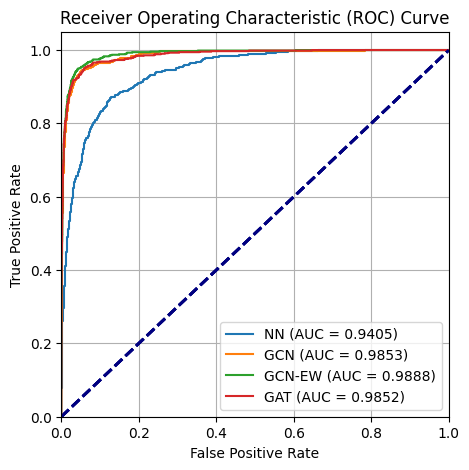

In [8]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots(figsize=(5, 5))
for name, model in models.items():
    prob = predict_prob(model, X_test, edge_index)
    y_probs = prob.view(-1, 2)

    fpr, tpr, thresholds = roc_curve(Y_test.view(-1), y_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format(model.name, roc_auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")
ax.grid()
plt.show()



In [9]:
# performance evaluation
metrics = evaluate_performance(models, X_test, Y_test, edge_index, device)
df = pd.DataFrame(metrics)
print(df)

    model    TN   FP   FN   TP precision  recall      f1     auc     fpr  \
0      NN  5681  619  123  577    0.7306  0.8630  0.7737  0.9405  0.0983   
1     GCN  6001  299   46  654    0.8393  0.9434  0.8817  0.9853  0.0475   
2  GCN-EW  6077  223   44  656    0.8696  0.9509  0.9047  0.9888  0.0354   
3     GAT  6187  113  101  599    0.9126  0.9189  0.9157  0.9852  0.0179   

      fnr loss_train loss_val acc_train acc_val accuracy  
0  0.1757     0.3704   0.6192    0.9076  0.8886   0.8940  
1  0.0657     0.1447   0.3883    0.9615  0.9511   0.9507  
2  0.0629     0.1034   0.3694    0.9729  0.9611   0.9619  
3  0.1443     0.0025   1.4405    0.9992  0.9693   0.9694  


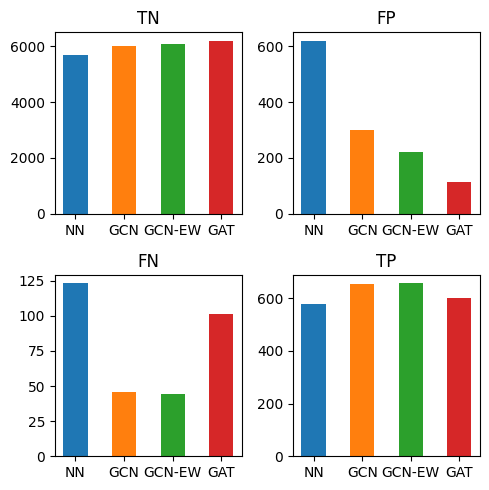

In [10]:
# plot the TP, FP, TN, FN
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()

bar_width = 0.5
labels = ['TN', 'FP', 'FN', 'TP']

for i, label in enumerate(labels):
    for j, name in enumerate(models):
        rects = axs[i].bar(j, metrics[j][label], width=bar_width, label=name)
    axs[i].set_xticks(np.arange(len(models)))
    axs[i].set_xticklabels(models.keys())
    for tick in axs[i].xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    axs[i].set_title(label)

handles, labels = axs[0].get_legend_handles_labels()

plt.tight_layout()
plt.show()


In [11]:
# robustness evaluation
for i in range(Y_test.shape[0]):
    for j in range(len(action_mask)):
        if Y_test[i, j] == 1:
            for k in range(rt_meas_dim):
                if True:
                    X_test[i, action_mask[j],-rt_meas_dim+k] -= torch.normal(mean=0.0, std=0.05, size=(1,)).item()

metrics = evaluate_performance(models, X_test, Y_test, edge_index, device)
df = pd.DataFrame(metrics)
print(df)

    model    TN   FP   FN   TP precision  recall      f1     auc     fpr  \
0      NN  5681  619  167  533    0.7171  0.8316  0.7554  0.9115  0.0983   
1     GCN  6003  297   73  627    0.8333  0.9243  0.8711  0.9783  0.0471   
2  GCN-EW  6076  224   84  616    0.8598  0.9222  0.8876  0.9795  0.0356   
3     GAT  6187  113  139  561    0.9052  0.8917  0.8983  0.9774  0.0179   

      fnr loss_train loss_val acc_train acc_val accuracy  
0  0.2386     0.3704   0.6192    0.9076  0.8886   0.8877  
1  0.1043     0.1447   0.3883    0.9615  0.9511   0.9471  
2  0.1200     0.1034   0.3694    0.9729  0.9611   0.9560  
3  0.1986     0.0025   1.4405    0.9992  0.9693   0.9640  


In [12]:
from torch_geometric.data import Data
from torch_geometric.explain import GNNExplainer, Explainer

# individual case analysis
found = False
while not found:
    indi_case_id = torch.randint(0, X_test.shape[0], (1,)).item()
    y_true = Y_test[indi_case_id]
    if y_true.sum() != 0:
        found = True
        print('indi_case_id: ', indi_case_id)

indi_case_x = X_test[indi_case_id]
indi_case_x = indi_case_x.unsqueeze(0)


indi_case_id:  96


model prob_ts: 
 tensor([9.2970e-15, 1.0000e+00, 7.8395e-18, 2.3087e-18, 1.2212e-03, 5.9830e-13,
        4.1746e-09], grad_fn=<IndexBackward0>)
y_true:  tensor([0., 1., 0., 0., 0., 0., 0.])


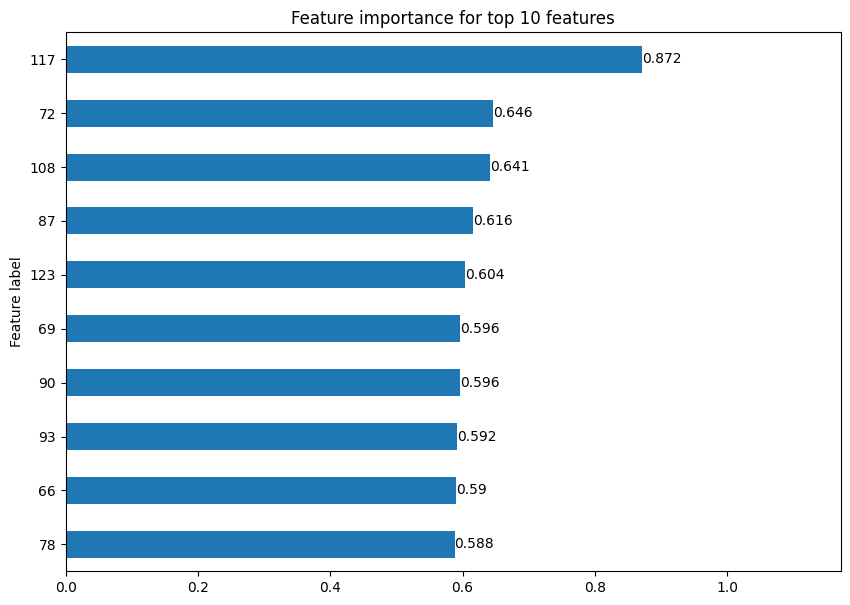

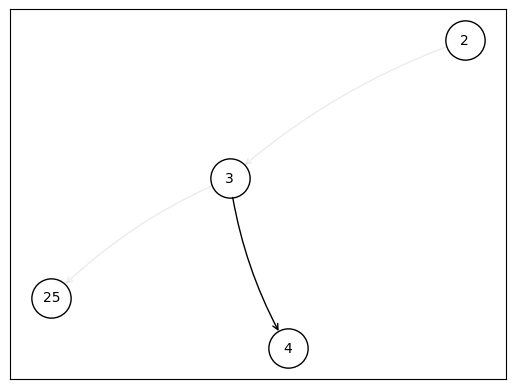

In [13]:
# Explainability visualization
model_to_explain = model_GCN_EW
model_to_explain.eval()
if model.name in ['GAT']:
    indi_case_x = indi_case_x.view(-1, in_dim)
prob_ts = torch.sigmoid(model_to_explain(indi_case_x, edge_index))[action_mask]
print('model prob_ts: \n', prob_ts)
print('y_true: ', y_true)

data = Data(x=X_test[indi_case_id], edge_index=edge_index)

explainer = Explainer(
    model=model_to_explain,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    ),
)

compromised_node = action_node_idx[np.where(y_true==1)[0].item()]
explanation = explainer(data.x, data.edge_index, index=compromised_node)

explanation.visualize_feature_importance(top_k=10)
explanation.visualize_graph()
